14226	4742		BILL
7970	2657		POLICY CHANGE
3276	1092		REINSTATEMENT NOTICE
7298	2433		CANCELLATION NOTICE
3619	1207		DELETION OF INTEREST
667	222		CHANGE ENDORSEMENT
726	242		DECLARATION
6730	2243		BINDER
217	72		BILL BINDER
550	184		EXPIRATION NOTICE
172	57		APPLICATION
468	156		NON-RENEWAL NOTICE
562	187		RETURNED CHECK
172	57		INTENT TO CANCEL NOTICE
Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 83.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 200.5min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 274.6min finished


Best score via grid search is 0.8702977300495145

Best Parameters are:

{'clf__alpha': 1e-05, 'clf__loss': 'log', 'clf__penalty': 'l1', 'tfidf__use_idf': True, 'vect__max_df': 0.8, 'vect__max_features': 10000, 'vect__ngram_range': (1, 2)}
Accuracy of SVM via grid search = 0.8708764709664973

Classification Report is as follows:

                         precision    recall  f1-score   support

            APPLICATION       0.81      0.61      0.70        57
                   BILL       0.89      0.91      0.90      4742
            BILL BINDER       0.24      0.08      0.12        72
                 BINDER       0.85      0.88      0.87      2243
    CANCELLATION NOTICE       0.85      0.87      0.86      2433
     CHANGE ENDORSEMENT       0.90      0.82      0.86       222
            DECLARATION       0.69      0.19      0.29       242
   DELETION OF INTEREST       0.92      0.89      0.91      1207
      EXPIRATION NOTICE       0.85      0.72      0.78       184
INTENT TO CANCEL N

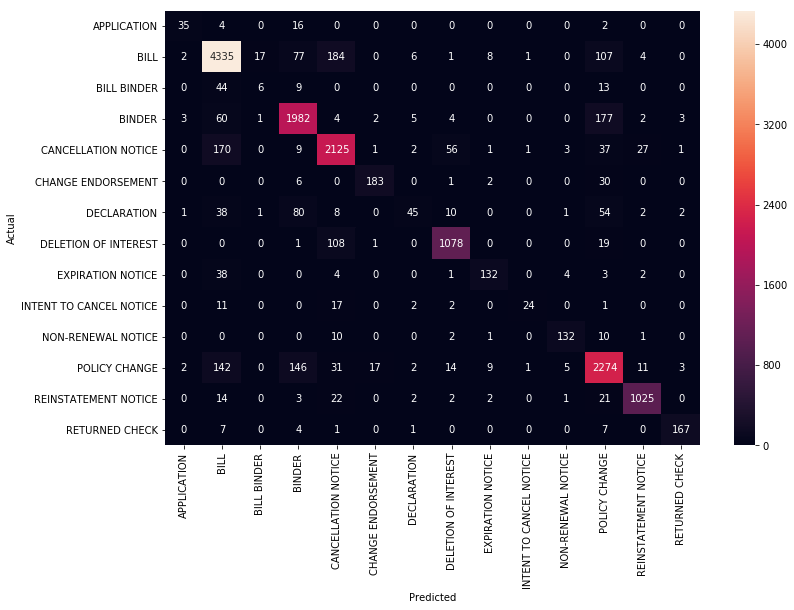

In [2]:
import numpy as np, os, pickle, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter


# Loading the data from file
X = []
Y = []
with open('data.csv','r') as data:
    for line in data:

        temp = (line.split(','))
        Y.append(temp[0])
        X.append(temp[1].strip())


count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25,stratify=Y)

# Just viewing count of each class
d_train = Counter(Y_train)
d_test = Counter(Y_test)
for i in d_train:
    print( str(d_train[i]) + "\t" + str(d_test[i]) + "\t\t" + i)

# Classifier Pipeline
svm_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),  ('clf', SGDClassifier(max_iter=10))])

# Parameters for cross-validation
parameters_svm = {'clf__alpha': [1e-4,1e-5,2e-5],'clf__loss' : ['log'],
                       'clf__penalty':['l1','l2'],'tfidf__use_idf': [True,False],
                     'vect__max_features':[3000,4000,5000,6000,10000],
                    'vect__ngram_range': [ (1,2)],'vect__max_df':[0.7,0.8]}



# Performing Grid Search Cross Validation
gs_svm_clf = GridSearchCV(svm_clf, parameters_svm, n_jobs=-1,verbose=True,cv=5)
gs_svm_clf = gs_svm_clf.fit(X_train, Y_train)
print("Best score via grid search is", gs_svm_clf.best_score_)
print("\nBest Parameters are:\n")
print(gs_svm_clf.best_params_)
prediction = gs_svm_clf.predict(X_test)
print("Accuracy of SVM via grid search = " + str(np.mean(prediction == Y_test)))


# CLassification report
clf_report = classification_report(Y_test,prediction)
print("\nClassification Report is as follows:\n")
print(clf_report)
cnf_matrix = confusion_matrix(Y_test, prediction)
x = clf_report.split('\n')
class_names = []
for j in range(1,len(cnf_matrix)+2):
    class_names.append(''.join([i for i in x[j] if not i.isdigit() or not '.' or not ' ']).replace('.','').strip())
class_names = class_names[1:]

# Plotting Confusion Matrix
print("Confusion Matrix is \n",cnf_matrix)
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(cnf_matrix, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



# Saving the model using Pickle
dest = os.path.join('pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)
pickle.dump(gs_svm_clf,open(os.path.join(dest, 'log_classifier.pkl'),'wb'),protocol=4)
